# Trend Weighted Fuzzy Time Series by Cheng, Chen and Wu (2009)

C.-H. Cheng, Y.-S. Chen, and Y.-L. Wu, “Forecasting innovation diffusion of products using trend-weighted fuzzy time-series model,” 
Expert Syst. Appl., vol. 36, no. 2, pp. 1826–1832, 2009.


# Common Imports

In [1]:
import matplotlib.pylab as plt
from pyFTS.benchmarks import benchmarks as bchmk
from pyFTS.models import cheng

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Data Loading

In [2]:
from pyFTS.data import Enrollments

enrollments = Enrollments.get_data()


# Exploring the partitioning effects on original data

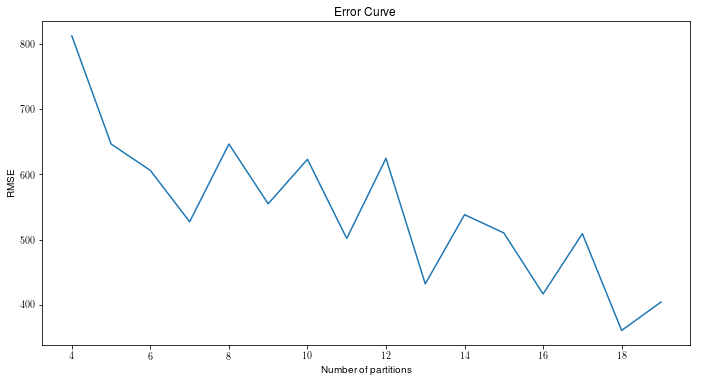

In [3]:
tmp = bchmk.simpleSearch_RMSE(enrollments, enrollments, cheng.TrendWeightedFTS, 
                              range(4,20), [1], tam=[10, 5])

# Exploring the partitioning effects on transformed data

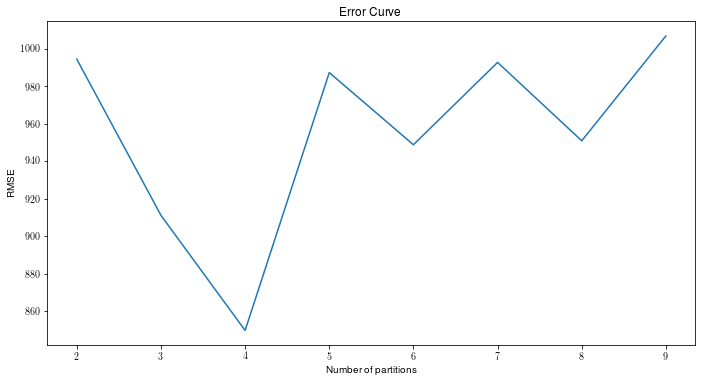

In [4]:
from pyFTS.common import Transformations
diff = Transformations.Differential(1)

tmp = bchmk.simpleSearch_RMSE(enrollments, enrollments, cheng.TrendWeightedFTS, 
                              range(2,10), [1], transformation=diff, tam=[10, 5])

# Comparing the partitioning schemas

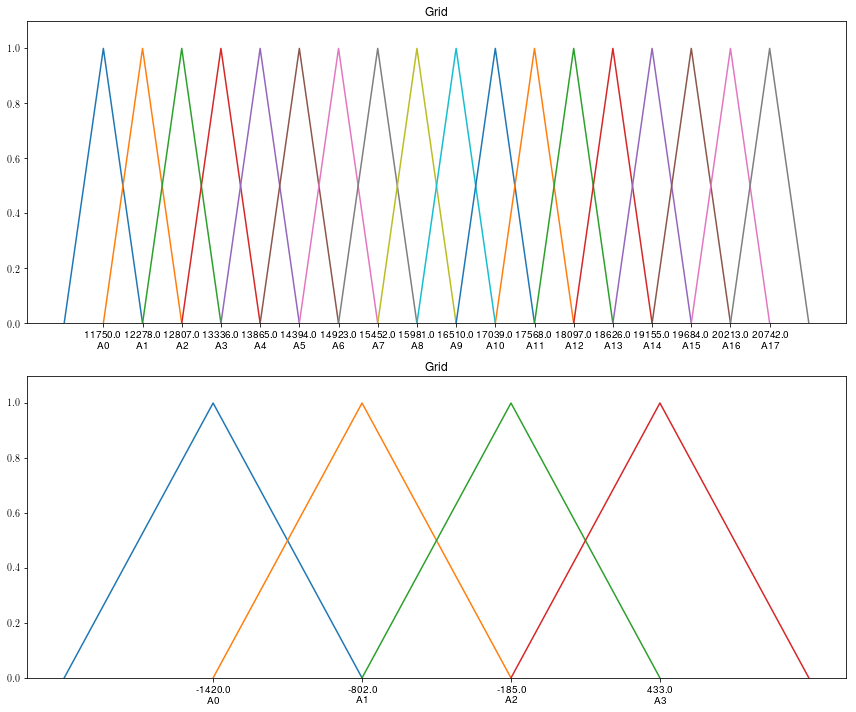

In [6]:
from pyFTS.partitioners import Grid, Util as pUtil

fuzzy_sets = Grid.GridPartitioner(data=enrollments, npart=18)
fuzzy_sets2 = Grid.GridPartitioner(data=enrollments, npart=4, transformation=diff)

pUtil.plot_partitioners(enrollments, [fuzzy_sets,fuzzy_sets2])

# Fitting a model on original data

In [7]:
model1 = cheng.TrendWeightedFTS("FTS", partitioner=fuzzy_sets)
model1.fit(enrollments)

print(model1)

Trend Weighted FTS:
A10 -> A10(0.167),A12(0.333),A9(0.5)
A12 -> A14(1.0)
A14 -> A13(0.167),A14(0.333),A14(0.5)
A2 -> A3(1.0)
A3 -> A4(1.0)
A4 -> A6(1.0)
A6 -> A6(0.167),A7(0.333),A8(0.5)
A7 -> A6(0.067),A7(0.133),A7(0.2),A7(0.267),A8(0.333)
A8 -> A10(0.333),A10(0.667)
A9 -> A7(1.0)



# Fitting a model on transformed data

In [11]:
model2 = cheng.TrendWeightedFTS("FTS Diff", partitioner=fuzzy_sets2)
model2.append_transformation(diff)
model2.fit(enrollments)

print(model2)

Trend Weighted FTS:
A0 -> A1(1.0)
A1 -> A0(0.036),A1(0.071),A1(0.107),A2(0.143),A2(0.179),A2(0.214),A3(0.25)
A2 -> A1(0.022),A1(0.044),A1(0.067),A1(0.089),A2(0.111),A2(0.133),A3(0.156),A3(0.178),A3(0.2)
A3 -> A2(0.1),A2(0.2),A2(0.3),A3(0.4)



# Using the models

In [12]:
model1.predict(enrollments)

[13336.366666666669,
 13865.322222222225,
 14923.233333333337,
 15584.427777777782,
 15452.188888888893,
 15452.188888888893,
 15452.188888888893,
 17039.055555555562,
 17215.37407407408,
 17215.37407407408,
 15452.188888888893,
 15452.188888888893,
 15452.188888888893,
 15584.427777777782,
 15584.427777777782,
 17039.055555555562,
 17215.37407407408,
 19154.877777777787,
 19022.638888888898,
 19022.638888888898,
 19022.638888888898,
 18625.92222222223]

In [13]:
model2.predict(enrollments)

[12740.168421052631,
 13245.846428571429,
 13552.168421052631,
 14378.846428571429,
 15142.846428571429,
 15214.435714285715,
 15288.168421052631,
 15546.168421052631,
 16489.84642857143,
 16604.168421052633,
 16291.435714285715,
 15336.435714285715,
 15182.168421052631,
 15048.435714285715,
 14848.168421052631,
 15666.846428571429,
 16541.84642857143,
 17347.55,
 18652.84642857143,
 19013.168421052633,
 19022.168421052633,
 18779.435714285715]

# Comparing the models

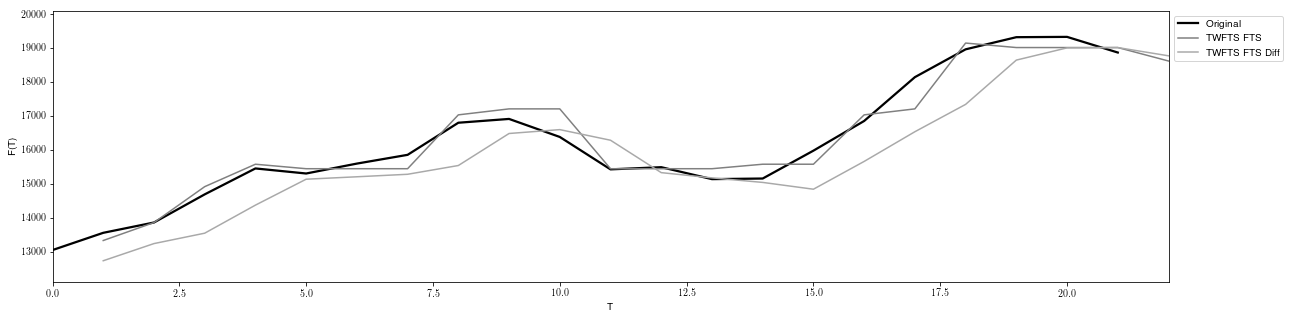

In [14]:
bchmk.plot_compared_series(enrollments, [model1, model2], bchmk.colors, intervals=False)

In [15]:
bchmk.print_point_statistics(enrollments, [model1, model2])

Model		& Order     & RMSE		& SMAPE      & Theil's U		\\ 
TWFTS FTS		& 1		& 361.36		& 0.85		& 0.59	\\ 
TWFTS FTS Diff		& 1		& 849.57		& 2.18		& 1.39	\\ 



# Residual Analysis

In [ ]:
from pyFTS.benchmarks import ResidualAnalysis as ra

ra.plot_residuals(enrollments, [model1, model2])